In [2]:
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [3]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

### Masking Seasonality
We have previously modeled the effect of nfl sundays using additional regressors. We could also view the NFL weeks as having a completly different weekly seasonality that offseason weeks, which means that we would like to have two different weekly seasonality curves. This can be modeled by adding two weekly seasonalities, and then having one masked depending on season.

In [4]:
m = Prophet(holidays=holidays, weekly_seasonality=False)
m.add_seasonality('nfl_weekly', period=7, 
                  fourier_order=3, condition_name='has_nfl_weekly')
m.add_seasonality('offseason_weekly', period=7,
                  fourier_order=3, condition_name='has_offseason_weekly')

df['has_nfl_weekly'] = (df['ds'].dt.month > 8) | (df['ds'].dt.month < 2)
df['has_offseason_weekly'] = ~df['has_nfl_weekly']
m.fit(df)

future = m.make_future_dataframe(periods=366)
future['has_nfl_weekly'] = (future['ds'].dt.month > 8) | (future['ds'].dt.month < 2)
future['has_offseason_weekly'] = ~future['has_nfl_weekly']
forecast = m.predict(future)

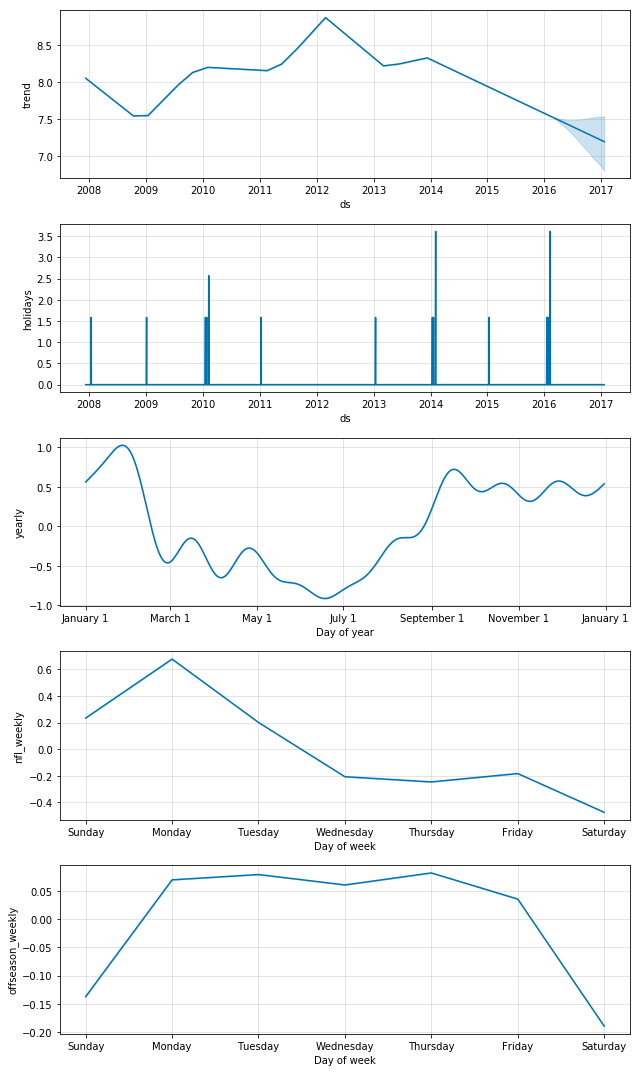

In [5]:
fig = m.plot_components(forecast)